/tmp/ipykernel_36/1475878528.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_36/1475878528.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_36/1475878528.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


✅ 已保存 Accuracy_Bootstrap 到文件 CNNs+Transformer bootstrap_accuracy.csv

=== Final Test Set Performance ===
Test Acc: 98.13% | F1: 0.9798 | Sensitivity: 0.9813 | PPV: 0.9806 | Specificity: 0.9265
🕒 Inference Time on Test Set: 0.32 seconds

=== Confidence Intervals (95%) ===
Accuracy: 98.1399 [97.8768, 98.3802]
F1 Score: 0.9799 [0.9771, 0.9827]
Sensitivity: 0.9814 [0.9788, 0.9841]
Precision: 0.9806 [0.9778, 0.9833]
Specificity: 0.9264 [0.9159, 0.9375]


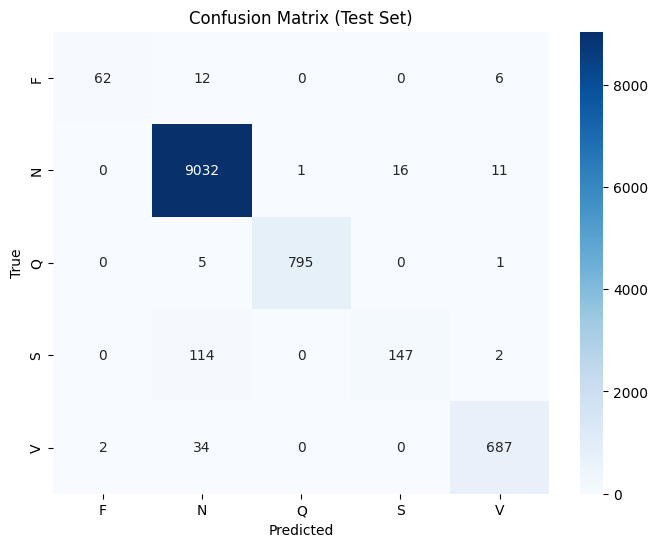


=== Model Complexity (via fvcore) ===
📊 Params: 327.62 K
📊 FLOPs: 13.85 M


CNNTransformerModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (embedding): Linear(in_features=64, out_features=128, bias=True)
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=Tru

In [5]:
#### -*- coding: utf-8 -*-
"""
Created on Wed Jan  8 13:58:40 2025

@author: 29551
"""
!pip install fvcore
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis, parameter_count
import time
# 读取数据
data = pd.read_csv('/kaggle/input/mit-bih/ECG_data.csv')

# 提取信号和标签
signals = data['Signal'].apply(lambda x: np.fromstring(x[1:-1], sep=',')).values
labels = data['Label'].values

# 转换信号为 NumPy 数组
signals = np.array([np.array(signal) for signal in signals])

# 转换信号为 PyTorch 张量
signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # 增加通道维度 (N, 1, 300)

# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


# 划分训练和测试集
X_train, X_temp, y_train, y_temp = train_test_split(
    signals, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded)

# 第二步：将临时集中的 2/3 设为验证集（20%），1/3 设为测试集（10%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Focal Loss 定义
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)  # 计算 p_t
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()



# Transformer 模块定义
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + self.dropout(attn_output))  # 残差连接 + LayerNorm

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.layernorm2(x + self.dropout(ff_output))  # 残差连接 + LayerNorm
        return x

# 分类模型定义
class CNNTransformerModel(nn.Module):
    def __init__(self, input_length, num_classes, embed_dim=128, num_heads=4, ff_dim=256, num_layers=2, dropout=0.2):
        super(CNNTransformerModel, self).__init__()
        # CNN 特征提取模块
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Transformer 模块
        self.embedding = nn.Linear(64, embed_dim)  # 将 CNN 输出特征映射到 Transformer 输入
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

        # 分类层
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # CNN 模块
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)  # 输出维度: (batch_size, channels, seq_length)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        # 转置以适配 Transformer 输入
        x = x.permute(0, 2, 1)  # 转换为 (batch_size, seq_length, features)
        x = self.embedding(x)   # 映射到 Transformer 嵌入维度 (batch_size, seq_length, embed_dim)

        # Transformer 模块
        for transformer in self.transformer_blocks:
            x = transformer(x)

        # 分类模块
        x = x.mean(dim=1)  # 全局平均池化 (batch_size, embed_dim)
        outputs = self.fc(x)  # 全连接层
        return outputs

# 模型、损失函数和优化器
input_length = 300
num_classes =5
model = CNNTransformerModel(input_length=input_length, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数
criterion = FocalLoss()  # 使用 Focal Loss
def specificity_score_weighted(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + np.diagonal(cm)
    fp = cm.sum(axis=0) - np.diagonal(cm)
    spec_per_class = tn / (tn + fp + 1e-6)
    class_support = cm.sum(axis=1)
    total = class_support.sum()
    return np.sum((class_support / total) * spec_per_class)
def save_bootstrap(y_true, y_pred, metric_fn, num_iterations=1000, alpha=0.05, csv_path="CNNs+Transformer bootstrap_accuracy.csv"):

    n = len(y_true)
    stats = []

    for _ in range(num_iterations):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        stat = metric_fn(np.array(y_true)[indices], np.array(y_pred)[indices])
        stats.append(stat)

    # === 如果是 Accuracy 就保存 ===
    if metric_fn.__name__ == "accuracy_score":
        try:
            df = pd.read_csv(csv_path)
        except FileNotFoundError:
            df = pd.DataFrame()

        df["CNNs+Transformer Accuracy_Bootstrap"] = stats  # 直接覆盖或新增该列

        df.to_csv(csv_path, index=False)
        print(f"✅ 已保存 Accuracy_Bootstrap 到文件 {csv_path}")

    # === 返回均值 ± 置信区间 ===
    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return np.mean(stats), lower, upper
def compute_test_metrics(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    
    start_time = time.time()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    sensitivity = recall_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    tn = conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + np.diagonal(conf_matrix)
    fp = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
    specificity_per_class = tn / (tn + fp + 1e-6)
    samples_per_class = conf_matrix.sum(axis=1)
    total_samples = np.sum(samples_per_class)

    specificity = np.sum((samples_per_class / total_samples) * specificity_per_class)

    
    # === CI 计算 ===
    acc_m, acc_l, acc_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=accuracy_score
    )

    f1_m, f1_l, f1_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: f1_score(y_t, y_p, average='weighted')
    )

    rec_m, rec_l, rec_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: recall_score(y_t, y_p, average='weighted')
    )

    ppv_m, ppv_l, ppv_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=lambda y_t, y_p: precision_score(y_t, y_p, average='weighted')
    )

    spe_m, spe_l, spe_u = save_bootstrap(
        y_true=all_targets,
        y_pred=all_predictions,
        metric_fn=specificity_score_weighted  # ✅ 你自定义的函数
    )
    ci_dict = {
        'Accuracy': (acc_m*100, acc_l*100, acc_u*100),
        'F1 Score': (f1_m, f1_l, f1_u),
        'Sensitivity': (rec_m, rec_l, rec_u),
        'Precision': (ppv_m, ppv_l, ppv_u),
        'Specificity': (spe_m, spe_l, spe_u)
    }

    return accuracy, f1, sensitivity, precision, specificity, conf_matrix, elapsed_time, ci_dict

def evaluate(model,test_loader):
    best_model_path = '/kaggle/input/cnn-transformer-best1/CNNsTransformer best_model.pth'

    # === 重新加载最优模型进行测试 ===
    model.load_state_dict(torch.load(best_model_path))
    model.eval()


    # === 测试集评估 ===
    test_acc, test_f1, test_sen, test_ppv, test_spe, conf_matrix, test_time, ci_dict = compute_test_metrics(model, test_loader)


    print("\n=== Final Test Set Performance ===")
    print(f"Test Acc: {test_acc:.2f}% | F1: {test_f1:.4f} | Sensitivity: {test_sen:.4f} | "
          f"PPV: {test_ppv:.4f} | Specificity: {test_spe:.4f}")
    print(f"🕒 Inference Time on Test Set: {test_time:.2f} seconds")

    print("\n=== Confidence Intervals (95%) ===")
    for metric, (mean, lower, upper) in ci_dict.items():
        print(f"{metric}: {mean:.4f} [{lower:.4f}, {upper:.4f}]")

    ci_df = pd.DataFrame({
        "Metric": list(ci_dict.keys()),
        "Mean": [v[0] for v in ci_dict.values()],
        "Lower CI (95%)": [v[1] for v in ci_dict.values()],
        "Upper CI (95%)": [v[2] for v in ci_dict.values()],
    })
    ci_df.to_csv("CNNs+Transformer_Test_Metrics_Confidence_Interval.csv", index=False)

    # 混淆矩阵图
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.savefig("CNNs+Transformer Confusion Matrix.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    # === 构造一个模拟输入，保持与模型输入一致 ===
    input_tensor = torch.randn(1, 1, X_train_tensor.shape[2]).to(next(model.parameters()).device)

    # === 使用 fvcore 分析 FLOPs 和参数量 ===
    flops = FlopCountAnalysis(model, input_tensor)
    params = parameter_count(model)

    # === 单位换算 ===
    flops_m = flops.total() / 1e6
    params_k = params[""] / 1e3

    # === 打印模型复杂度 ===
    print("\n=== Model Complexity (via fvcore) ===")
    print(f"📊 Params: {params_k:.2f} K")
    print(f"📊 FLOPs: {flops_m:.2f} M")

    # === 保存到文件 ===
    with open("CNNs+Transformer_Model_Complexity.txt", "w") as f:
        f.write(f"Params: {params_k:.2f} K\n")
        f.write(f"FLOPs: {flops_m:.2f} M\n")
        f.write(f"Test Time: {test_time:.2f} sec\n")
    return model

evaluate(model,test_loader)
        


